In [1]:
import joblib
import sys
import pathlib
import yaml
import subprocess

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

2025-05-12 00:16:17.776417: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-12 00:16:17.785594: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747030577.794885    8431 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747030577.797713    8431 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747030577.805763    8431 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
CELL_TYPE_COL = 'encode_celltype'
SAMPLE_ID_COL = 'sample_id'
STIM_COL = 'stim'
TECH_COL = 'samp_type'
DATASPLIT_COL = 'isTraining'

GENE_ID_COL = 'gene_ids'

In [3]:
# Get the root directory of the analysis repository
REPO_ROOT = subprocess.run(
    ["git", "rev-parse", "--show-toplevel"], capture_output=True, text=True
).stdout.strip()
REPO_ROOT = pathlib.Path(REPO_ROOT)

CONFIG_FILE = REPO_ROOT / 'config.yml'
assert CONFIG_FILE.exists(), f"Config file not found at {CONFIG_FILE}"

with open(CONFIG_FILE, 'r') as file:
    config_dict = yaml.safe_load(file)

In [4]:
buddi_fork_path = config_dict['software_path']['buddi_v2']
buddi_fork_path = pathlib.Path(buddi_fork_path)
assert buddi_fork_path.exists(), f"buddi fork not found at {buddi_fork_path}"

sys.path.append(str(REPO_ROOT))
sys.path.append(str(buddi_fork_path))
# this is quite ugly, once activate modifications are done this will be changed
# to a proper installation + import
from analysis_utils.buddi4data import BuDDI4Data
from buddi_v2.dataset.buddi4_dataset import get_supervised_dataset, get_unsupervised_dataset
from buddi_v2.models.buddi4 import fit_buddi4
from buddi_v2.models.components.losses import unsupervised_dummy_loss_fn
from buddi_v2.models.buddi4_class import BuDDI4
from buddi_v2.plotting.plot_latent_space import plot_latent_spaces_buddi4
from buddi_v2.plotting.plot_data import plot_data

I0000 00:00:1747030578.741764    8431 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4337 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5


In [5]:
PREPROCESSING_OUTPUT_PATH = REPO_ROOT / 'processed_data' 
train_data_file = PREPROCESSING_OUTPUT_PATH / 'buddi4_train_data.pkl'
assert train_data_file.exists(), f"Train data file not found at {train_data_file}"

In [6]:
train_data = joblib.load(train_data_file)
print(train_data)
print('\n')

n_x = len(train_data.gene_names)
n_y = len(train_data.cell_type_names)
n_labels = train_data.encode_meta[SAMPLE_ID_COL].shape[1]
n_stims = train_data.encode_meta[STIM_COL].shape[1]
n_samp_types = train_data.encode_meta[TECH_COL].shape[1]
print(f"Number of genes: {n_x}")
print(f"Number of cell types: {n_y}")
print(f"Number of unique labels: {n_labels}")
print(f"Number of unique stimulations: {n_stims}")
print(f"Number of unique sample types: {n_samp_types}")

BuDDIData(unkp_samples=588, kp_samples=8400, genes=7000, cell_types=11)


Number of genes: 7000
Number of cell types: 11
Number of unique labels: 593
Number of unique stimulations: 2
Number of unique sample types: 2


In [7]:
obj = BuDDI4.load(
    '/home/weishanli/CU/DavidsonLab/BuddiHGSC/HGSC_buddi_subtype_analysis/trained/buddi4_alpha=100.0_beta=10.0_beta_label=1.0_beta_slack=0.1'
)

In [8]:
# obj = BuDDI4.load(
#     '/home/weishanli/CU/DavidsonLab/BuddiHGSC/HGSC_buddi_subtype_analysis/trained/buddi4_alpha=100.0_beta=100.0_beta_slack=0.1'
# )

In [9]:
print(obj.encoders)
print(obj.decoder)
print(obj.prop_estimator)

{'label': <Functional name=encoder_label, built=True>, 'stim': <Functional name=encoder_stim, built=True>, 'samp_type': <Functional name=encoder_samp_type, built=True>, 'slack': <Functional name=encoder_slack, built=True>}
<Functional name=shared_X_decoder, built=True>
<Functional name=prop_estimator, built=True>


In [10]:
from analysis_utils.validation.perturb_sample import perturb_sample, perturb_bulk_sample
from analysis_utils.validation.resample import reconstruct
from analysis_utils.validation.plot_perturb import plot_perturb_reduction, plot_corr_matrix_with_metadata

In [11]:
from analysis_utils.validation.perturb_z import _perturb_z

In [12]:
from analysis_utils.validation.integrate import integrate_z, integrate_y

In [13]:
def plot_reconstruction(
    x_reconstruct,
    meta_reconstruct,
    reduction_method = 'UMAP',
    color_by = ['sample_id', 'stim'],
    palette = 'tab20'
):
    from sklearn.decomposition import PCA
    from umap.umap_ import UMAP
    
    fig, ax = plt.subplots(1, len(color_by), figsize=(5 * len(color_by), 5))

    if reduction_method == 'PCA':
        reducer = PCA(n_components=2)
        coords = reducer.fit_transform(x_reconstruct, ensure_all_finite=True)
    elif reduction_method == 'UMAP':
        pca_reducer = PCA(n_components=30)
        pca = pca_reducer.fit_transform(x_reconstruct)
        reducer = UMAP(n_components=2, random_state=42, n_jobs=1)
        coords = reducer.fit_transform(pca, ensure_all_finite=True)

    df_reduction = pd.DataFrame(
        coords, columns=[f'{reduction_method}1',f'{reduction_method}2'])
    df_reduction = pd.concat(
        [df_reduction, meta_reconstruct.reset_index(drop=True)], axis=1)
    df_reduction['dataset'] = 'perturb'
    
    for i, col in enumerate(color_by):
        # Plot the reconstructed data
        sns.scatterplot(
            data=df_reduction,
            x=f'{reduction_method}1',
            y=f'{reduction_method}2',
            hue=col,
            palette=palette,
            ax=ax[i],
            alpha=0.7
        )
        ax[i].set_title(f'Reconstructed Data {col}')
        if df_reduction[col].nunique() > 20:
            ax[i].legend([],[], frameon=False)
    
    plt.tight_layout()
    plt.show()

In [14]:
X = train_data.get('unkp', 'X')
y = train_data.get('unkp', 'Y')
meta = train_data.get('unkp', 'meta')
meta.head()

,sample_id,stim,samp_type,isTraining,cell_prop_type,cell_type
19291X171,19291X171,black,bulk,Train,bulk,bulk
19291X249,19291X249,black,bulk,Train,bulk,bulk
20160X121,20160X121,white,bulk,Train,bulk,bulk
18341X26,18341X26,black,bulk,Train,bulk,bulk
20160X247,20160X247,white,bulk,Train,bulk,bulk


In [15]:
selected_samples = np.random.choice(
    meta[meta[STIM_COL] == 'black'][SAMPLE_ID_COL].unique(), 
    size=5, 
    replace=False)
idx = np.where(meta[SAMPLE_ID_COL].isin(selected_samples))[0]
print(selected_samples)

['19291X295' '18341X28' '19291X176' '19291X39' '19291X21']


In [20]:
x_reconst_sample_perturb, sample_perturb_meta = perturb_bulk_sample(
    obj,
    data=train_data,
    idx=idx,
    n_resamples=20
)

Perturbing label ...: 100%|██████████| 5/5 [00:08<00:00,  1.77s/it]


/home/weishanli/anaconda3/envs/buddi_conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


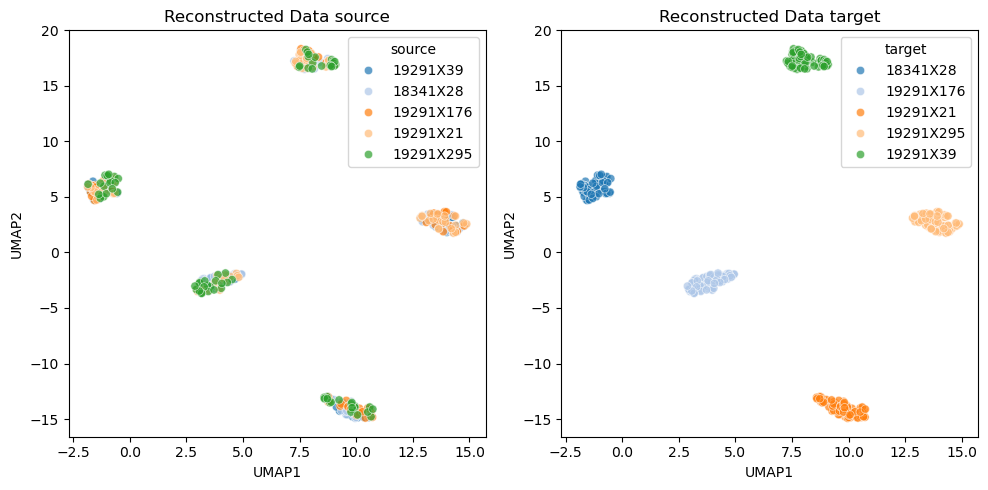

In [21]:
plot_reconstruction(
    x_reconst_sample_perturb,
    sample_perturb_meta,
    reduction_method='UMAP',
    color_by=['source', 'target']
)

In [13]:
x_reconstruct, meta_reconstruct = reconstruct(
    obj=obj,
    data=train_data,
    idx=None,
    n_resamples=20,
    seed=42,
    random_uniform_y=True,
    condition='unkp'
)

/home/weishanli/anaconda3/envs/buddi_conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


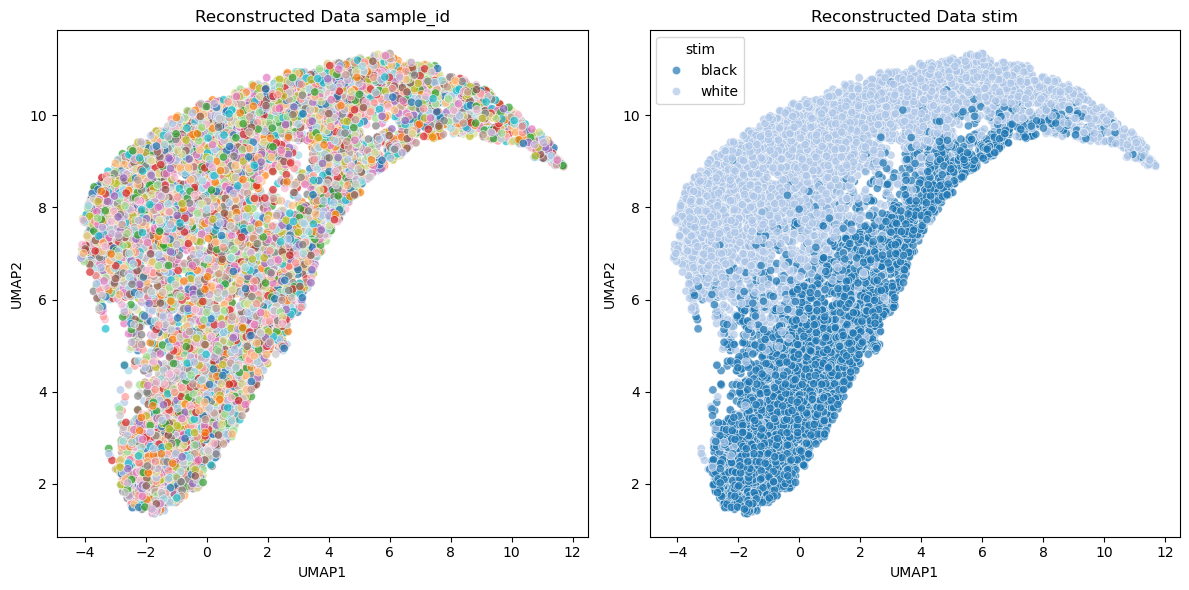

In [15]:
plot_reconstruction(
    x_reconstruct,
    meta_reconstruct,
    reduction_method='UMAP',
    
)

In [16]:
selected_samples = np.random.choice(
    meta[meta[STIM_COL] == 'black'][SAMPLE_ID_COL].unique(), 
    size=5, 
    replace=False)
idx = np.where(meta[SAMPLE_ID_COL].isin(selected_samples))[0]
print(selected_samples)

sample_col = SAMPLE_ID_COL
int_over = [
    'stim', 'samp_type', 'slack'
]
ignore_samples = []
n_subsamples = 1
n_resamples = 200
seed = 42
rng = np.random.default_rng(seed)
sample_branch_name = 'label'

['19291X123' '18341X27' '19291X296' '19291X228' '19291X242']


In [17]:
X_sub, y_sub = X[idx,:], y[idx,:]
meta_sub = meta.iloc[idx].copy()

branch_names = list(obj.encoder_branch_names)
if 'slack' in obj.encoders:
    branch_names += ['slack']

z_params = []
for branch in branch_names:
    z_param = obj.encoders[branch](X_sub).numpy()
    z_params.append(z_param)
z_params_int = {}
for i, branch in enumerate(branch_names):
    z_params_int[branch] = np.mean(z_params[i], axis=0, keepdims=True)

sample_names = meta_sub[sample_col].unique()
sample_to_idx = {sample: np.where(meta_sub[sample_col] == sample)[0]
                for sample in sample_names}
valid_samples = [sample for sample, rows in sample_to_idx.items() if rows.size > 0]
valid_samples = [sample for sample in valid_samples if sample not in ignore_samples]

y_hat = obj.prop_estimator(X_sub).numpy()
y_hat_mean = np.mean(y_hat, axis=0, keepdims=True)
y_hat_mean_expanded = np.broadcast_to(y_hat_mean, y_hat.shape)
y_hat_int = y_hat_mean_expanded

recons, metas = [], []

for src in valid_samples:
    for tgt in valid_samples:
        if src == tgt:
            continue

        src_rows = sample_to_idx[src]
        tgt_rows = sample_to_idx[tgt]

        pick_src = rng.choice(src_rows, size=n_subsamples, replace=True)
        pick_tgt = rng.choice(tgt_rows, size=n_subsamples, replace=True)

        zs_perturb = []
        for branch in branch_names:
            z_resample = []

            if branch in int_over:
                zp = z_params_int[branch]
            else:
                if branch != sample_branch_name:
                    _x = X_sub[pick_src, :]
                else:
                    _x = X_sub[pick_tgt, :]
                zp = obj.encoders[branch](_x)

            for _ in range(n_resamples):                
                tf.random.set_seed(seed) # re-seed for every inference
                z_resample.append(obj.reparam_layers[branch](zp).numpy())

            z_resample = np.vstack(z_resample)
            zs_perturb.append(z_resample)

        _y = np.tile(
            y_hat[pick_src, :],
            (n_resamples, 1)
        )

        with tf.device('/CPU:0'):
            recon = obj.decoder([_y] + zs_perturb).numpy()

        recons.append(recon)
        perturb_meta = pd.DataFrame(
            data={
                'reconstruction_type': 'perturbed',
                'perturb_type': sample_col,
                'source': [src]*n_subsamples,
                'target': [tgt]*n_subsamples
            }
        )
        _meta = meta_sub.iloc[pick_src, :].reset_index(drop=True)
        _meta = pd.concat([_meta] * n_resamples, axis=0)
        perturb_meta = pd.concat([perturb_meta, _meta], axis=1)
        metas.append(perturb_meta)

x_reconst_sample_perturb = np.vstack(recons)
sample_perturb_meta = pd.concat(metas, ignore_index=True)
sample_perturb_meta.reset_index(drop=True, inplace=True)

In [18]:
from sklearn.decomposition import PCA
from umap.umap_ import UMAP

reduction_method = 'UMAP'

pca_reducer = PCA(n_components=30)
pca_perturb = pca_reducer.fit_transform(x_reconst_sample_perturb)
reducer = UMAP(n_components=2, random_state=42, n_jobs=1)
coords_perturb = reducer.fit_transform(pca_perturb, ensure_all_finite=True)

df_perturb = pd.DataFrame(coords_perturb, columns=[f'{reduction_method}1',f'{reduction_method}2'])
df_perturb = pd.concat([df_perturb, sample_perturb_meta.reset_index(drop=True)], axis=1)
df_perturb['dataset'] = 'perturb'

/home/weishanli/anaconda3/envs/buddi_conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [19]:
selected_samples[0]

'19291X123'

<Axes: xlabel='UMAP1', ylabel='UMAP2'>

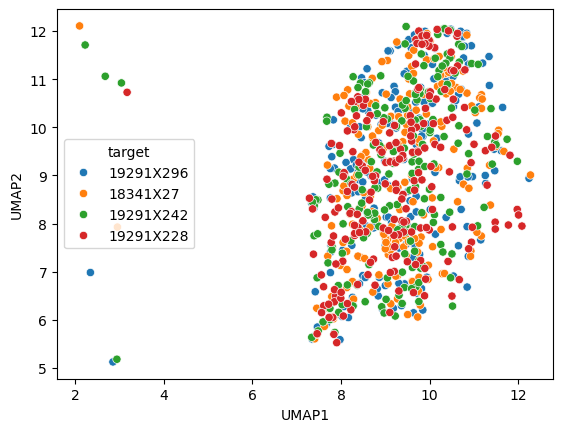

In [20]:
sns.scatterplot(
            data=df_perturb[df_perturb['source'] == selected_samples[0]],
            x=f'{reduction_method}1', y=f'{reduction_method}2',
            hue='target', 
            legend='brief',
            style=None,
        )